In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time

from datetime import datetime
from math import log, sqrt, exp
from scipy import stats

### 实现关键函数

In [2]:
def bsm_call_value(S0, K, T, r, sigma):
    """
    期权报价
    :param S0: 标的资产在0时刻的价格水平
    :param K: 期权的执行价格
    :param T: 期权的到期期限
    :param r: 常数的无风险短期利率
    :param sigma: 资产常数的隐含波动率（标准差）
    """
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return value


def bsm_vega(S0, K, T, r, sigma):
    """
    期权定价公式关于波动率的一阶导数称为期权的Vega
    """
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(T)
    return vega


def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, iter=100):
    """
    求隐含波动率

    :param C0: 欧式看涨期权价格
    :param sigma_est: sigma迭代初值
    :param iter: 迭代次数
    """
    for i in range(iter):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0)
            / bsm_vega(S0, K, T, r, sigma_est))
    return sigma_est

### 数据加载

In [4]:
V0 = 17.6639
r = 0.01

h5 = pd.HDFStore('./vstoxx_data_31032014.h5')
futures_data = h5['futures_data']  # 期货价格 一个到期日一份合约
options_data = h5['options_data']  # 期权数据 到期日和执行价格
h5.close()

In [5]:
print(futures_data)

          DATE  EXP_YEAR  EXP_MONTH  PRICE   MATURITY    TTM
496 2014-03-31      2014          4  17.85 2014-04-18  0.049
497 2014-03-31      2014          5  19.55 2014-05-16  0.126
498 2014-03-31      2014          6  19.95 2014-06-20  0.222
499 2014-03-31      2014          7  20.40 2014-07-18  0.299
500 2014-03-31      2014          8  20.70 2014-08-15  0.375
501 2014-03-31      2014          9  20.95 2014-09-19  0.471
502 2014-03-31      2014         10  21.05 2014-10-17  0.548
503 2014-03-31      2014         11  21.25 2014-11-21  0.644


In [6]:
print(options_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       395 non-null    datetime64[ns]
 1   EXP_YEAR   395 non-null    int64         
 2   EXP_MONTH  395 non-null    int64         
 3   TYPE       395 non-null    object        
 4   STRIKE     395 non-null    float64       
 5   PRICE      395 non-null    float64       
 6   MATURITY   395 non-null    datetime64[ns]
 7   TTM        395 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB
None


In [7]:
print(options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head())

            DATE   MATURITY    TTM  STRIKE  PRICE
46170 2014-03-31 2014-04-18  0.049     1.0  16.85
46171 2014-03-31 2014-04-18  0.049     2.0  15.85
46172 2014-03-31 2014-04-18  0.049     3.0  14.85
46173 2014-03-31 2014-04-18  0.049     4.0  13.85
46174 2014-03-31 2014-04-18  0.049     5.0  12.85


### imp_vol（隐含波动率）计算

隐含波动率 (implied volatility, imp_vol) 是由期权的市场价格反推得到的波动率参数。

给定标的价格、执行价格 (strike)、到期时间、利率等，代入 Black-Scholes 或其他定价模型，解出能让理论价格 = 市场价格的波动率，就是 imp_vol。

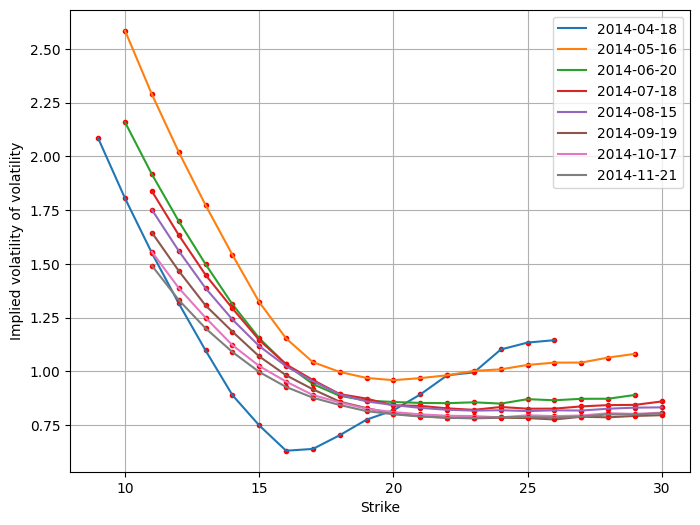

                   PRICE   IMP_VOL
MATURITY   STRIKE                 
2014-04-18 9.0      8.85  2.083388
           10.0     7.85  1.804193
           11.0     6.85  1.550283
           12.0     5.85  1.316103
           13.0     4.85  1.097184
...                  ...       ...
2014-11-21 26.0     2.20  0.785411
           27.0     2.05  0.789241
           28.0     1.95  0.800016
           29.0     1.80  0.798958
           30.0     1.70  0.805459

[158 rows x 2 columns]


In [10]:
import warnings
warnings.filterwarnings("ignore")
# 对每一个期权合约计算imp_vol，要求期权的执行价格不远离forward price
# 执行价格不能定价错误 F(1-tol) < K < F(1+tol)
options_data['IMP_VOL'] = 0.0
tol = 0.5  # tolerance
for option in options_data.index:
    forward = futures_data[futures_data['MATURITY'] ==
                           options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    if forward * (1-tol) < options_data.loc[option]['STRIKE'] < forward * (1 + tol):
        imp_vol = bsm_call_imp_vol(V0,
                                   options_data.loc[option]['STRIKE'],
                                   options_data.loc[option]['TTM'],
                                   r,
                                   options_data.loc[option]['PRICE'],
                                   sigma_est=2.,
                                   iter=100)
        options_data['IMP_VOL'].loc[option] = imp_vol

plot_data = options_data[options_data['IMP_VOL'] > 0]
maturites = sorted(set(options_data['MATURITY']))

plt.figure(figsize=(8, 6))
for maturity in maturites:  # 迭代到期日
    data = plot_data[options_data['MATURITY'] == maturity]
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.', label='_nolegend_')  # setting label='' also works
    plt.plot(data['STRIKE'], data['IMP_VOL'], label=pd.Timestamp(maturity).date(), lw=1.5)
plt.grid(True)
plt.xlabel('Strike')
plt.ylabel('Implied volatility of volatility')
plt.legend()
plt.show()

keep = ['PRICE', 'IMP_VOL']
group_data = plot_data.groupby(['MATURITY', 'STRIKE'])[keep]
# print(group_data)
group_data = group_data.sum()
print(group_data)

隐含波动率的大小含义

IV 高

市场认为未来标的资产的价格会更不稳定。

说明市场对未来有较强的不确定性或风险预期（比如重大事件、财报发布、政策风险、战争消息）。

期权价格会变贵（因为买方愿意为对冲风险支付更高溢价）。

IV 低

市场认为未来标的资产走势比较平稳。

投资者预期价格不会出现太大波动。